#### Описание данных:

*date* - дата\
*time* - время\
*event* - действие (просмотр/клик)\
*platform* - платформа\
*ad_id* - id объявления\
*client_union_id* - id рекламного кабинета\
*campain_union_id* - id рекламной компании\
*ad_cost_type* - тип оплаты\
*ad_cost* - цена\
*has_video* - есть ли видео\
*target_audience_count* - размер аудитории

ads_clients_data.csv характеристики рекламных клиентов:\
*date* - дата\
*client_union_id* - id рекламного кабинета\
*community_id* - id сообщества\
*create_date* - дата создания рекламного клиента

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px

%matplotlib inline

# Зададим размер рисунка
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
    )

In [8]:
# Данные рекламы
ads_data = pd.read_csv('ads_data.zip', compression='zip')

In [9]:
# Данные рекламных клиентов
ads_clients_data = pd.read_csv('ads_clients_data.csv')

In [10]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [11]:
ads_data.dtypes

date                      object
time                      object
event                     object
platform                  object
ad_id                      int64
client_union_id            int64
campaign_union_id          int64
ad_cost_type              object
ad_cost                  float64
has_video                  int64
target_audience_count      int64
dtype: object

In [12]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [13]:
# проверим типы данных
ads_clients_data.dtypes

date               object
client_union_id     int64
community_id        int64
create_date        object
dtype: object

#### Для начала посчитаем среднее количество разных рекламных событий (показы и клики) по объявлениям.

#### Тонкий момент: некоторые показываемые объявления не кликались, и при группировке в таких случаях не будет строк с кликами, а для подсчета среднего по объявлениям их нужно учитывать.

In [82]:
data_group_event = (
    ads_data.groupby(['ad_id', 'event'], as_index=False)
    .agg({'date': 'count'})
    .pivot(index='ad_id', columns='event', values='date')
    .reset_index()
    .fillna(0)
)

In [83]:
data_group_event.head()

event,ad_id,click,view
0,2,1.0,101.0
1,3,3.0,184.0
2,1902,1.0,41.0
3,2064,0.0,35.0
4,2132,1.0,58.0


Посмоотрим на среднее количество кликов и просмотров по оъявлениям.

In [84]:
click_mean = data_group_event.click.mean()

In [85]:
view_mean = data_group_event.view.mean()

In [87]:
print('Количество кликов в среднем - ', round(click_mean))

Количество кликов в среднем -  113


In [88]:
print('Количество просмотров в среднем - ', round(view_mean))

Количество просмотров в среднем -  923


#### Давайте посмотрим на распределение показов объявлений.
Прологарифмируем число показов, а затем построим такой график, чтобы можно было понять форму распределения.

In [89]:
# По оси х - число показов
# По оси у - доля объявлений с такими показами

In [90]:
# Отберем только количество показов для каждого объявления.
count_view = data_group_event[['view']]

In [91]:
count_view.head()

event,view
0,101.0
1,184.0
2,41.0
3,35.0
4,58.0


In [92]:
# Прологарифмировать нули нельзя, поэтому нужно заменить
count_view = count_view.view.replace(0 , 1)

In [93]:
# Прологарифмируем значения в колонке, вернет колонку с логарифмом исходных значений.
log_view = np.log(count_view)

In [94]:
log_view

0      4.615121
1      5.214936
2      3.713572
3      3.555348
4      4.060443
         ...   
960    4.605170
961    5.049856
962    4.219508
963    4.927254
964    3.737670
Name: view, Length: 965, dtype: float64

C:\Users\uszai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='view', ylabel='Density'>

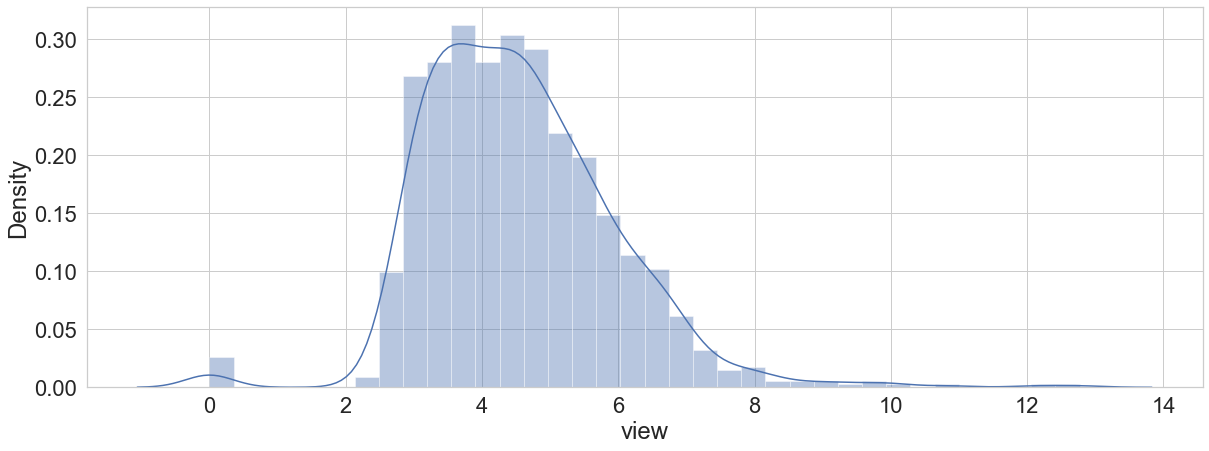

In [95]:
# Нарисуем график распределения просмотров
sns.distplot(log_view)

Найдем среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, 
у которых не было показов (обычное среднее). После этого посчитаем скользящее среднее по полученному результату с окном
в 2 элемента.

#### Попробуем найти значение скользящего среднего за 6 апреля 2019 года.

In [96]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [124]:
# Сгруппировали по ad_id и по date, нашли количество просмотров
count_view = (
    ads_data.query('event == "view"')
    .groupby(['ad_id', 'date'], as_index=False)
    .agg({'event': 'count'})
)

In [125]:
count_view.head()

,ad_id,date,event
0,2,2019-04-01,83
1,2,2019-04-02,18
2,3,2019-04-01,158
3,3,2019-04-02,26
4,1902,2019-04-03,34


In [126]:
# Снова сгруппировали по дате и посчитали среднее количество просмотром по датам
count_view = count_view.groupby('date').agg({'event': 'mean'})

In [127]:
count_view = count_view.rename(columns = {'event': 'count_mean'})

In [128]:
count_view #среднее количество просмотров по датам

,count_mean
date,
2019-04-01,154.482270
2019-04-02,137.786982
2019-04-03,163.952778
2019-04-04,675.901720
2019-04-05,919.109677
2019-04-06,277.122727


In [129]:
# Посчитали скользящее среднее по полученному результату с окном в 2 элемента
roll_mean = count_view.rolling(2).mean().reset_index()

In [130]:
roll_mean

,date,count_mean
0,2019-04-01,NaN
1,2019-04-02,146.134626
2,2019-04-03,150.869880
3,2019-04-04,419.927249
4,2019-04-05,797.505699
5,2019-04-06,598.116202


In [131]:
roll_mean = roll_mean.rename(columns={'count_mean': 'roll_mean'})
roll_mean

,date,roll_mean
0,2019-04-01,NaN
1,2019-04-02,146.134626
2,2019-04-03,150.869880
3,2019-04-04,419.927249
4,2019-04-05,797.505699
5,2019-04-06,598.116202


#### Скользящее среднее часто используется для аномалий данных. Давайте попробуем нанести на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных(которое мы получили в прошлом шаге).

Посчитаем, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним.
Дни, в которых скользящее среднее равно Nan, не учитываем.

In [132]:
# Среднее количество заказов по дням
count_view = count_view.reset_index()

In [133]:
# Среднее количество заказов по дням
count_view

,date,count_mean
0,2019-04-01,154.482270
1,2019-04-02,137.786982
2,2019-04-03,163.952778
3,2019-04-04,675.901720
4,2019-04-05,919.109677
5,2019-04-06,277.122727


In [134]:
roll_mean

,date,roll_mean
0,2019-04-01,NaN
1,2019-04-02,146.134626
2,2019-04-03,150.869880
3,2019-04-04,419.927249
4,2019-04-05,797.505699
5,2019-04-06,598.116202


C:\Users\uszai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\uszai\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='roll_mean', ylabel='Density'>

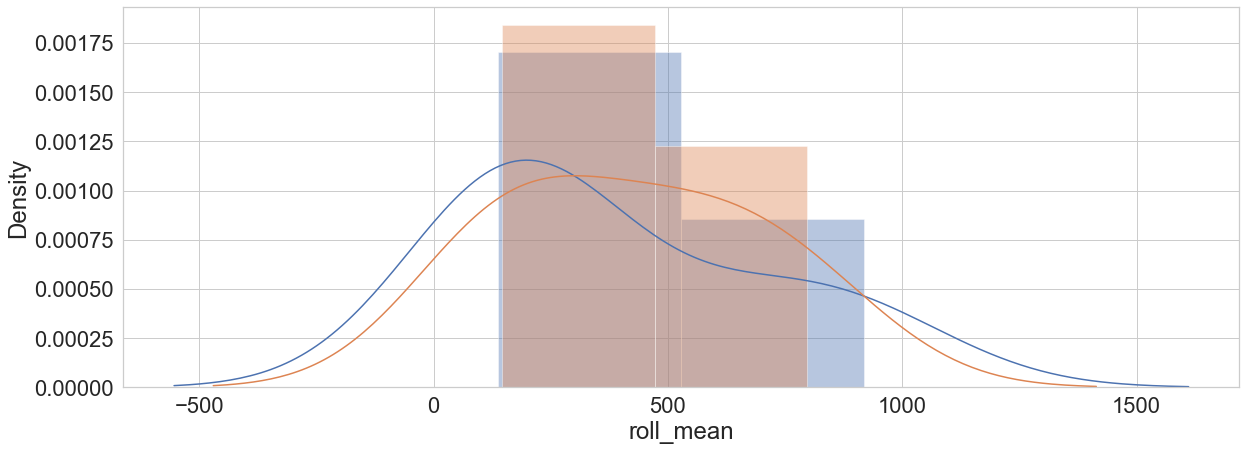

In [135]:
sns.distplot(count_view.count_mean)
sns.distplot(roll_mean.roll_mean)

In [136]:
# Объединим датафреймы для получения разницы по модулю между арифметическим средним и скользящим средним в дальнейшем.
merge_count = count_view.merge(roll_mean, how='inner', on='date')

In [137]:
merge_count

,date,count_mean,roll_mean
0,2019-04-01,154.482270,NaN
1,2019-04-02,137.786982,146.134626
2,2019-04-03,163.952778,150.869880
3,2019-04-04,675.901720,419.927249
4,2019-04-05,919.109677,797.505699
5,2019-04-06,277.122727,598.116202


In [138]:
# Добавили колонку delta с разницей между арифметическим средним и скользящим средним
merge_count['delta'] = abs(merge_count.count_mean - merge_count.roll_mean)

In [139]:
merge_count

,date,count_mean,roll_mean,delta
0,2019-04-01,154.482270,NaN,NaN
1,2019-04-02,137.786982,146.134626,8.347644
2,2019-04-03,163.952778,150.869880,13.082898
3,2019-04-04,675.901720,419.927249,255.974471
4,2019-04-05,919.109677,797.505699,121.603979
5,2019-04-06,277.122727,598.116202,320.993475


In [140]:
# Вернули данные для которых разница максимальна
merge_count[merge_count.delta == merge_count.delta.max()]

,date,count_mean,roll_mean,delta
5,2019-04-06,277.122727,598.116202,320.993475


#### Объединим данные рекламы с данными о рекламных клиентах и найдем среднее количество дней от даты создания рекламного  клиента(create_date) и первым запуском рекламного объявления этим клиентом(date).

#### Найдем среднее число дней.

In [141]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [142]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [143]:
# Объединили таблицы на основании client_union_id
merge_ads = ads_data.merge(ads_clients_data, on='client_union_id')

In [144]:
merge_ads.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04


In [145]:
# Поменяли данные у date_x и create_date
merge_ads.date_x = pd.to_datetime(merge_ads.date_x)
merge_ads.create_date = pd.to_datetime(merge_ads.create_date)

In [146]:
merge_ads.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04


In [147]:
# Из даты посещения вычли дату создания кабинета
merge_ads['delta'] = merge_ads.date_x - merge_ads.create_date

In [148]:
merge_ads.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date,delta
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04,118 days


In [149]:
# Сгруппировали по client_union_id и посчитали среднее для delta
mean_delta = (
    merge_ads.groupby('client_union_id', as_index=False)
    .agg({'delta': 'mean'})
    .sort_values('delta')
)

In [150]:
mean_delta.delta.mean()

Timedelta('124 days 15:38:55.524424108')

#### Давайте вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

Конверсия - отношение числа клиентов, которые совершии целевое действие (создали рекламу), к общему числу клиентов.
Например 1000 клиентов создали кабинет, но лишь 50 из них запустили рекламу.

#### Чтобы отобрать данные за нужный прромежуток, можно воспользоваться сравнением времени до создания первой рекламы с pd.Timedelta(365, unit = 'day')

NB! У нас могут быть люди, которые не сделали рекламу вообще.

In [151]:
# Возьмем первоначальные данные для объединения

In [152]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [153]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [154]:
# Посчитаем количество уникальных кабинетов в данных только по кабинетам
unique_clients_data = ads_clients_data.client_union_id.nunique()
unique_clients_data

122078

In [155]:
# Посчитаем количество уникальных кабинетов, у которых есть хотя бы одна реклама, в данных по рекламам.

In [156]:
unique_data = ads_data.client_union_id.nunique()
unique_data

838

In [157]:
# Исходя из того, что у нас нет клиентов, которые создали рекламу больше чем через 365 дней. Поэтому находим конверсию
round(unique_data / unique_clients_data * 100, 2)

0.69

Конверсия из создания рекламного кабинета в запуск первой рекламы составила **0.69%**

#### Давайте разобьем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления. Определим, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования(от 0 да 30 дней).
Список промежутков дней для метода pd.cut() - [0, 30, 90, 180, 365].

In [160]:
# Нашли дату первого объявления для клиентов
first_ad = (
    merge_ads.groupby('client_union_id', as_index=False)
    .agg({'date_x': 'min'})
)

In [161]:
# Нашли список дат создания рекламных кабинетов
create_d = (
    merge_ads.groupby('client_union_id', as_index=False)
    .agg({'create_date': 'min'})
)

In [162]:
# Объединили фреймы
date_megre = first_ad.merge(create_d)

In [163]:
# Добавили колонку времени разница между датами создания первого объявления и датой создания кабинета.
date_megre['delta'] = date_megre.date_x - date_megre.create_date

In [164]:
date_megre.head()

,client_union_id,date_x,create_date,delta
0,1,2019-04-01,2018-12-24,98 days
1,9,2019-04-03,2018-12-10,114 days
2,13,2019-04-02,2019-01-26,66 days
3,16,2019-04-03,2018-12-19,105 days
4,20,2019-04-02,2019-03-01,32 days


In [165]:
# Список промежутков дней для метода pd.cut() - [0, 30, 90, 180, 365]. Создать временные промежутки можно с помощью 
#  pd.to_timedelta().
date_megre['delta'] = (
    pd.cut(date_megre.delta, pd.to_timedelta(['0d', '30d', '90d', '180d', '365d']),
    labels = ['0-30 days', '30-90 days', '90-180 days', '180-365 days'])
)

In [166]:
# Узнали в какие промежутки входят наши клиенты
date_megre.delta.value_counts()

90-180 days     396
30-90 days      263
180-365 days    168
0-30 days        11
Name: delta, dtype: int64

С помощью сегментации клиентов видим, что большая часть запускает первое рекламное объявления после создания рекламного кабинета в промежутке **от 90 до 180 дней**.

#### Построить интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них (то, что у вас получилось на прошлом степе, по запуску  первого рекламного объявления). 

In [168]:
date_megre.head()

,client_union_id,date_x,create_date,delta
0,1,2019-04-01,2018-12-24,90-180 days
1,9,2019-04-03,2018-12-10,90-180 days
2,13,2019-04-02,2019-01-26,30-90 days
3,16,2019-04-03,2018-12-19,90-180 days
4,20,2019-04-02,2019-03-01,30-90 days


<AxesSubplot:xlabel='delta', ylabel='count'>

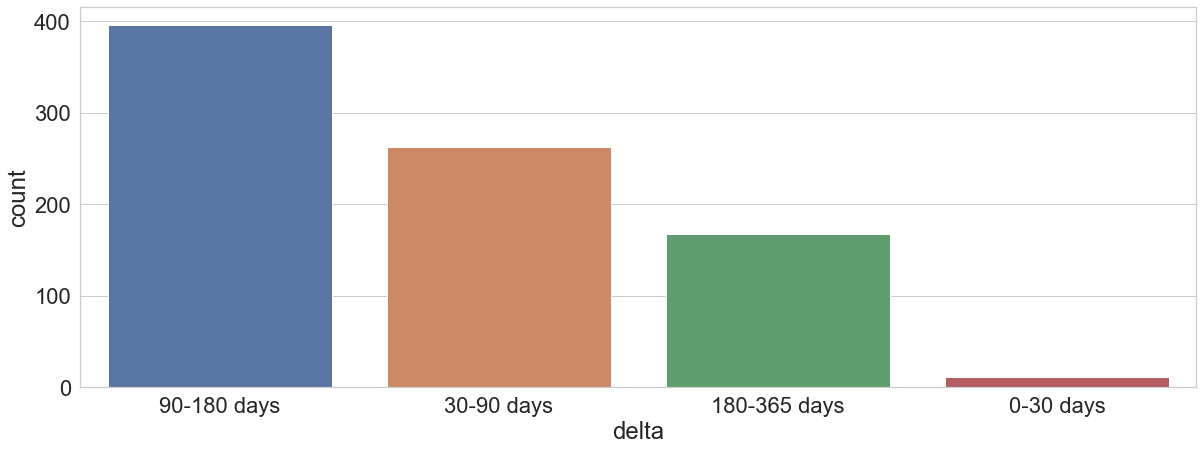

In [169]:
sns.countplot(x="delta", data=date_megre, order=date_megre['delta'].value_counts().index)